# 04. PyTorch Custom Datasets

We'll use `torchvision.datasets` to build custom datasets. 

#### The contents

Topic	Contents
0. Importing PyTorch and setting up device-agnostic code.
1. Get data	We're going to be using our own custom dataset of pizza, steak and sushi images.
2. Become one with the data (data preparation)	
3. Transforming data - here we'll look at some steps we can take to transform our images so they're ready to be used with a model.
4. Loading data with ImageFolder (option 1)	 ImageFolder is helpful if our images are in standard image classification format.
5. Loading image data with a custom Dataset	What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.
6. Other forms of transforms (data augmentation) 
7. Model 0: TinyVGG without data augmentation
8. Exploring loss curves
9. Model 1: TinyVGG with data augmentation
10. Compare model results	
11. Making a prediction on a custom image trained model predict on an image outside of our existing dataset.

### 1.Get data from GitHub

In [1]:
import requests
import zipfile
from pathlib import Path 

# setup data folder 
data_path = Path("D:\\Coding_Stuff\\GitHub\\ZTM-PyTorch\\data")
image_path = data_path / "pizza_steak_sushi"

# if imagefolder does not exist 
if image_path.is_dir():
    print(f"{image_path} directory exists ")
else:
    print(f"Did not find {image_path} directory , creaitng one...")

    with open(data_path / "/pizza_steak_sushi.zip", "wb") as f:
        image_path.mkdir(parents=True, exist_ok=True)

        link = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

        request = requests.get(link)
        f.write(request.content)

        # unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / "/pizza_steak_sushi.zip", "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data ... ")
            zip_ref.extractall(image_path)


D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi directory exists 


### 2. Becomming one with the data

Preparing data...... 

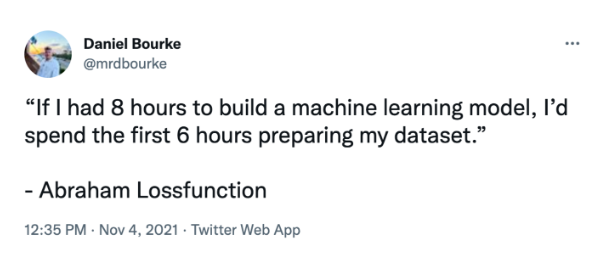


Image classification format contains seperate class of images in seperate directories , this is popular in many image classification benchmarks including the **ImageNet**

![Screenshot 2024-02-25 151120.png](<attachment:Screenshot 2024-02-25 151120.png>)


The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch

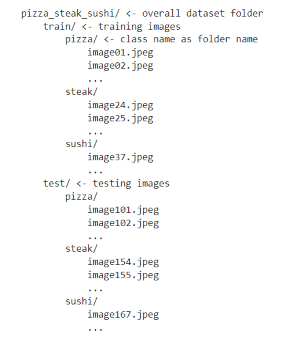

In [2]:
image_path

WindowsPath('D:/Coding_Stuff/GitHub/ZTM-PyTorch/data/pizza_steak_sushi')

In [3]:
import os 

def wal_through_dir(dir_path):
    """
    Args: 
        dir_path (str ot pathlib.Path); target directory 
    
    Returns:
        A print out of:
            number of subdirectories in dir_path 
            number of images (files) in each directory 
            name of each sub directory 
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

wal_through_dir(image_path)

There are 2 directories and 0 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\sushi'.


In [4]:
# setup train and test path 

train_path = image_path / "train"
test_path = image_path / "test"

train_path

WindowsPath('D:/Coding_Stuff/GitHub/ZTM-PyTorch/data/pizza_steak_sushi/train')

### 3. Visulize and Image

*visualize, visualize, visualize!*

- Get images path using python `pathlib.Path.glob` using end of files `.jpg`
- Pick a random image using python `random.choice()`
- Since we're working with images we'll open random image path using `PIL.Image.open()`



Random image path: D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test\pizza\416067.jpg
Image class: pizza
Image height: 512
Image width: 512


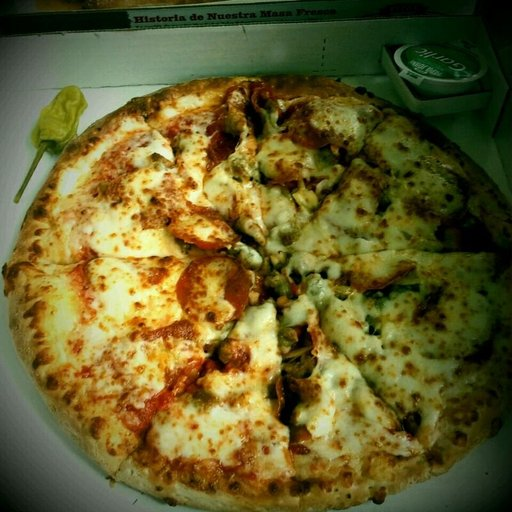

In [5]:
import random
import pathlib
from PIL import Image

# set seed 
random.seed(43)

# get all images file names 
image_path_list = list(image_path.glob(pattern="*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### 4. Transform Data

In PyTorch we need data into tensors for that :- 

Turn data into 
- `torch.utils.data.Dataloader` and subsequently a 
- `torch.utils.data.DataLoader` 

1. Vision	        `torchvision.datasets`
2. Audio	        `torchaudio.datasets`
3. Text	            `torchtext.datasets`
4. Recommendation system	`torchrec.datasets`


In [6]:
import torch 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms

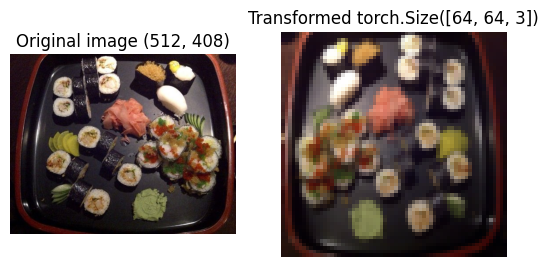

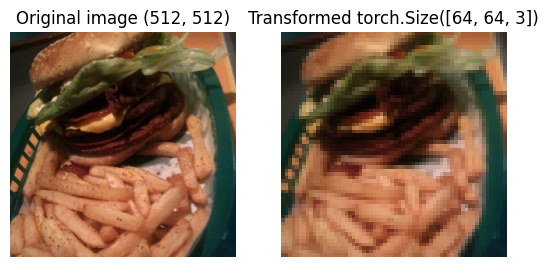

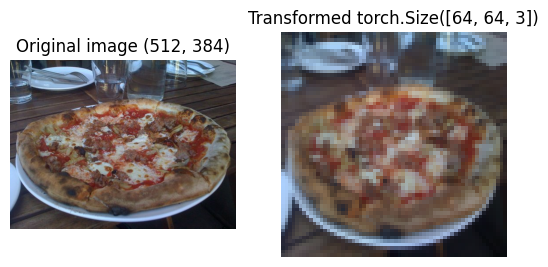

In [7]:
data_transform =  transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

def plot_transformed_image(image_paths, transform , n=3, seed=42):
    """ 
    Plot a series of random images from image_paths, will open 
    n image_path and plot them side by side

    Args:
        image_paths (platplib.Path) : target path 
        transforms (torchvision.transforms): the transform pipeline
        n (optional) and seed (optional)
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original image {f.size}")
            ax[0].axis("off")

            # Transfrom and plot 
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed {transformed_image.shape}")
            ax[1].axis("off")

plot_transformed_image(image_paths=image_path_list,
                       transform=data_transform)

### 4. Option 1: Load image using `ImageFolder`.

Since the data is already arranged in std image classification format we can use the `torchvision.datasets.ImageFolder` 


In [8]:
train_path

WindowsPath('D:/Coding_Stuff/GitHub/ZTM-PyTorch/data/pizza_steak_sushi/train')

In [9]:
from torchvision import datasets 

train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform,
                                 target_transform=None)

print("Train data   \n", train_data, "Test data     \n", test_data)

Train data   
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Test data     
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [10]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [11]:
img, label = train_data[0][0], train_data[0][1]
print("Image tensor \n", img[:1])
print("Image shape \n", img.shape)
print("Image datatype \n", img.dtype)
print("Image label \n", label)

Image tensor 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]]])
Image shape 
 torch.Size([3, 64, 64])
Image datatype 
 torch.float32
Image label 
 0


Text(0.5, 1.0, 'pizza')

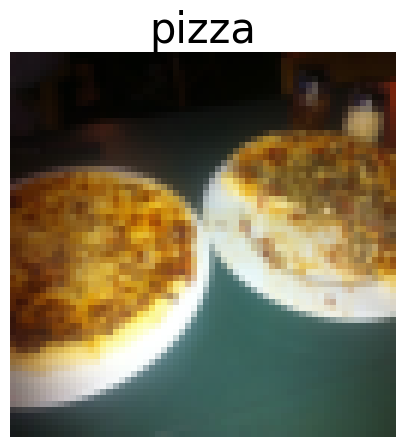

In [12]:
img_permute = img.permute(1,2,0)

plt.figure(figsize=(7,5))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize = 30)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset= train_data,
                              batch_size= 1,
                              num_workers= 1,
                            shuffle=True)

test_dataloader = DataLoader(dataset= test_data,
                             batch_size= 1,
                             num_workers= 1,
                             shuffle= True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27a3aa3a230>,
 <torch.utils.data.dataloader.DataLoader at 0x27a3aa3b910>)

In [14]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### 5. Option 2: Loading Image Data with custom `Dataset`.

- Python `os` for dealing with directories. 
- Python `pathlib` for dealing with filepaths 
- `torch` for all things PyTorch
- PIL's `Image` for images
- `torch.utils.data.Datasets` to subclass and create own custom `Dataset`.
- `torchvision.transforms`
- `typing` for type hints. 

In [15]:
import os 
import pathlib 
import torch 
from PIL import Image 
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from typing import Dict, List, Tuple

#### 5.1 Creating helper functions to get class names 

In [16]:
for i in os.scandir(image_path/"train"):
    print(i.name)
    print(i.path)

pizza
D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\pizza
steak
D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\steak
sushi
D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train\sushi


In [17]:
def find_classes(directory: str):
    """ Finds the class folder names in target directory. 
    Assumes target directry is in std image classification format.
    
    Args:
        directory (str): target directory to load images.
    Returns:
        Tuple[List[str]], Dict[str, int]
    """
    classes = sorted(entity.name for entity in os.scandir(directory) if entity.is_dir())

    if not classes:
        raise FileNotFoundError(f"Could not find any classes")
    
    classes_to_idx = {cls_names: i for i , cls_names in enumerate(classes)}

    return classes_to_idx, classes

find_classes(image_path/"train")

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

#### 5.2 Create custom `Dataset` to replicate `ImageFolder`.

Steps. 

1. Subclass `torch.utils.data.Dataset`
2. init our subclass with `tar_dir` param and `transform` param
3. Create several attributes for `paths` , `transform` ( this can be `None`), `classes` and `classes_to_ind` from out `find_classes` function. 
4. Create a function to load images from file and return them using `PIL` or `torchvision.io`
5. Override `__len__` method of `torch.utils.data.Dataset.` to return number of samples in `Dataset`
6. Override `__getiten__` method to return a single sample. 


In [18]:
from torch.utils.data import Dataset 

class CustomImageFolder(Dataset):
    def __init__(self, tar_dir: str, transform = None) -> None:

        # create class attributes
        self.paths = list(pathlib.Path(tar_dir).glob("*/*.jpg"))
        self.transform = transform 
        self.classes, self.class_to_idx = find_classes(tar_dir)

    # create function to load images 
    def load_images(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Overide the __len__ function
    def __len__(self) -> int:
        return len(self.paths)
    
    # overide the __getitem__
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        img = self.load_images(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx(class_name)

        # apply transform if exists
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx # return data, label (X,y)

In [19]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [20]:
train_data_custom = CustomImageFolder(transform=train_transforms,
                                      tar_dir=train_path)
test_data_custom = CustomImageFolder(transform=test_transforms,
                                     tar_dir=test_path)

train_data_custom, test_data_custom

(<__main__.CustomImageFolder at 0x27a38836a40>,
 <__main__.CustomImageFolder at 0x27a3a9c1330>)

In [21]:
len(train_data_custom), train_data_custom.classes , train_data_custom.class_to_idx

(225, {'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

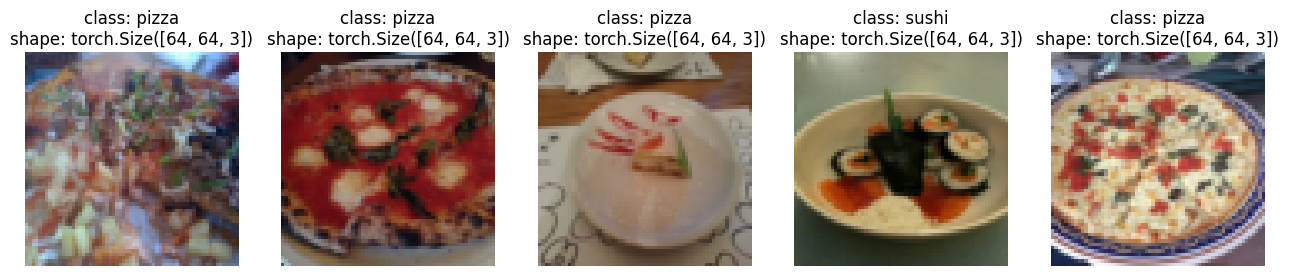

In [22]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

#### 5.5 CunstomImageFolder to `DataLoader`


In [23]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers= NUM_WORKERS,
                                     shuffle= True)

test_dataloader_custom = DataLoader(test_data_custom, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

train_dataloader_custom

### 6. Data Augmentation 

TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision model


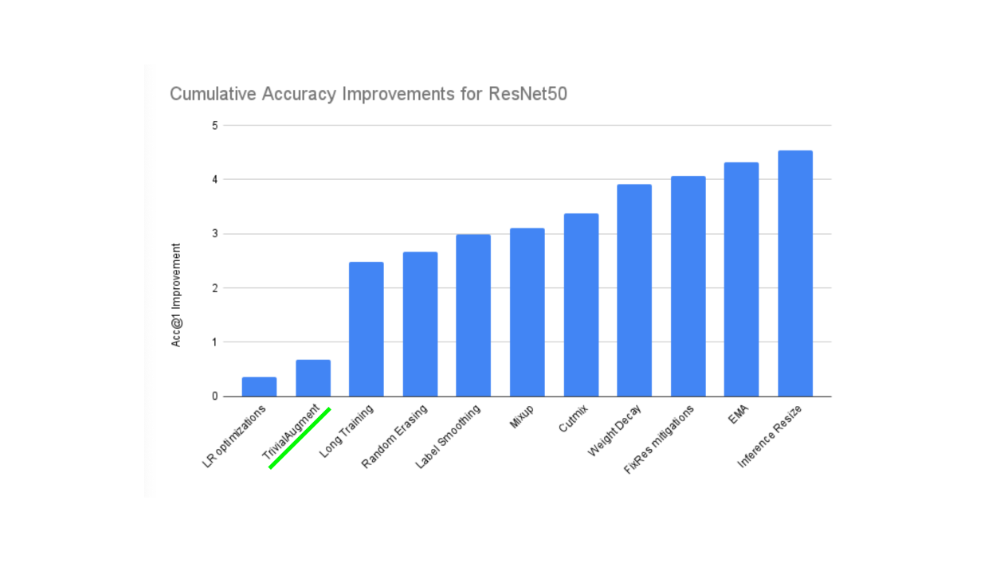

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31.`

It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity).

In [24]:
from torchvision import transforms 

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

### 7. Model0: TinyVGG without augmentation. 


In [25]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Load data into `Dataset` with `torch.utils.data.ImageFolder()` then turn them into `torch.utils.data.DataLoader`. 

In [26]:
from torchvision.datasets import ImageFolder 

train_data_simple = ImageFolder(root= train_path, transform=simple_transform)
test_data_simple = ImageFolder(root= test_path, transform= simple_transform)

import os 
from torch.utils.data import DataLoader

train_datalaoder_simple = DataLoader(train_data_simple,
                                     num_workers= os.cpu_count(),
                                     batch_size = 32,
                                     shuffle= True)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    num_workers=os.cpu_count(),
                                    shuffle=False,
                                    batch_size=32)

train_datalaoder_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x27a310b1060>,
 <torch.utils.data.dataloader.DataLoader at 0x27a38786920>)

**Creating Tiny VGG**

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
import torch.nn as nn 

class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_shape: int, output_shape: int)-> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_shape,
                      out_channels=hidden_shape,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_shape*16*16, out_features= output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        return self.classifier(x)

torch.manual_seed(42)
model0 = TinyVGG(input_shape=3, # number of color channels
                 output_shape=10,
                 hidden_shape=10)
model0.to(device)

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

In [29]:
img_batch, label_batch = next(iter(train_datalaoder_simple))

# get a singel image 
img_sample, label_sample = img_batch[0].unsqueeze(dim=0), label_batch[0]

print("Image sample size :\n", img_sample.shape)

model0.eval()
with torch.inference_mode():
    pred = model0(img_sample.to(device))

print(f"Output logits: \n{pred}\n")
print(f"Output prediction probabilities : \n {torch.softmax(pred, dim=1)} \n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_sample}")


Image sample size :
 torch.Size([1, 3, 64, 64])
Output logits: 
tensor([[ 0.0357,  0.0519,  0.0564, -0.0773, -0.0352,  0.0445, -0.0574,  0.0745,
         -0.0458,  0.0534]], device='cuda:0')

Output prediction probabilities : 
 tensor([[0.1025, 0.1041, 0.1046, 0.0915, 0.0954, 0.1034, 0.0933, 0.1065, 0.0944,
         0.1043]], device='cuda:0') 

Output prediction label:
tensor([7], device='cuda:0')

Actual label:
1


**Use `torchinfo` to get model summary and shapes**

In [30]:
import torchinfo 

torchinfo.summary(model= model0,
                  input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─MaxPool2d: 2-9                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Flat

**Create train and test loops**

In [31]:
from torchmetrics import Accuracy
accuracy = Accuracy(task='multiclass', num_classes=3)
accuracy.to(device)

MulticlassAccuracy()

In [32]:
from torchmetrics import Accuracy

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn = torch.nn.Module,
               optimizer = torch.optim):
    
    # put model in train mode 
    model.train()

    #setup train and test loss 
    train_loss, train_acc = 0,0 
    for batch, (X,y) in enumerate(dataloader):

        X,y = X.to(device), y.to(device)

        # Forward 
        y_pred = model(X)

        # Calculate and accumilate loss
        loss = loss_fn(y_pred, y)
        train_loss+= loss.item()

        # optimizer zerograd 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += accuracy(y_pred_class, y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc 

In [33]:
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader):
    
    model.eval()

    # setup test loss and acc 
    test_loss, test_acc = 0,0 

    for batch, (X,y) in enumerate(dataloader):

        X,y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        test_loss += loss.item()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
        test_acc += accuracy(y_pred_class,y)

    test_acc /= len(dataloader)
    test_loss /= len(dataloader)

    return test_loss, test_acc 

**Creating `train()` function to combine `train_step()` and `test_step`**

1. Take in a model, `DataLoader` for training and test sets, an optimizer and a loss function with epochs too. 
2. create empty dictionaries for `train_loss`, `train_acc`, `test_loss` and `test_acc`. 
3. loop through , print what's happening 
4. update the dictionaries and return them

In [34]:
from tqdm.auto import tqdm 

# take in various params required for training and tests 

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim,
          epochs: int):
    
    # empty dictionaries 
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]
               }
    
    # loop through 
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
    # update the dictionaries 
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    print(results)

    return results

c:\Users\kaila\Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Train and evaluate model**

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_shape=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)

# start timer 
from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_datalaoder_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total time to complete is {start_time-end_time}")

100%|██████████| 5/5 [01:17<00:00, 15.49s/it]

{'train_loss': [1.496246188879013, 1.0982060730457306, 1.1742006987333298, 1.1559880673885345, 1.1392236948013306], 'train_acc': [tensor(0.2734, device='cuda:0'), tensor(0.4141, device='cuda:0'), tensor(0.2891, device='cuda:0'), tensor(0.3203, device='cuda:0'), tensor(0.2734, device='cuda:0')], 'test_loss': [1.0704578558603923, 1.2537510395050049, 1.07861328125, 1.1487792531649272, 1.0971852540969849], 'test_acc': [tensor(0.5417, device='cuda:0'), tensor(0.1979, device='cuda:0'), tensor(0.5417, device='cuda:0'), tensor(0.2604, device='cuda:0'), tensor(0.1979, device='cuda:0')]}
Total time to complete is -77.4715470999945


In [36]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### Model 1: TinyVGG with Data Augmentation

Setting up `TrivialAugmentWide` and turn our dataset into `Dataset` using `torchvision.datasets.ImageFolder` and later into dataloader. 

In [37]:
train_transfor_augmentation = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [38]:
train_data_augmented = ImageFolder(root=train_path,
                                   transform=train_transfor_augmentation,
                                   target_transform=None)
test_data_simple = ImageFolder(root = test_path, 
                               transform=test_transforms)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: D:\Coding_Stuff\GitHub\ZTM-PyTorch\data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [39]:
# Turn Dataset into dataloader 
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x27a54b35780>,
 <torch.utils.data.dataloader.DataLoader at 0x27a54b35bd0>)

**Construct and train Model 1**

In [40]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_shape=10,
                  output_shape=len(train_data_augmented.classes))

model_1.to(device=device)
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

**Training**

- train for 5 epochs 

In [41]:
#setting up seed 
torch.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)

model_1_result = train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS)

100%|██████████| 5/5 [01:16<00:00, 15.23s/it]

{'train_loss': [1.1038513332605362, 1.0815337970852852, 1.093003123998642, 1.122251734137535, 1.0982867926359177], 'train_acc': [tensor(0.3906, device='cuda:0'), tensor(0.4258, device='cuda:0'), tensor(0.4258, device='cuda:0'), tensor(0.3047, device='cuda:0'), tensor(0.3047, device='cuda:0')], 'test_loss': [1.1607984105745952, 1.1803044478098552, 1.1665355364481609, 1.141863187154134, 1.148463765780131], 'test_acc': [tensor(0.2604, device='cuda:0'), tensor(0.2604, device='cuda:0'), tensor(0.2604, device='cuda:0'), tensor(0.2604, device='cuda:0'), tensor(0.1979, device='cuda:0')]}


In [42]:
model_1_result

{'train_loss': [1.1038513332605362,
  1.0815337970852852,
  1.093003123998642,
  1.122251734137535,
  1.0982867926359177],
 'train_acc': [tensor(0.3906, device='cuda:0'),
  tensor(0.4258, device='cuda:0'),
  tensor(0.4258, device='cuda:0'),
  tensor(0.3047, device='cuda:0'),
  tensor(0.3047, device='cuda:0')],
 'test_loss': [1.1607984105745952,
  1.1803044478098552,
  1.1665355364481609,
  1.141863187154134,
  1.148463765780131],
 'test_acc': [tensor(0.2604, device='cuda:0'),
  tensor(0.2604, device='cuda:0'),
  tensor(0.2604, device='cuda:0'),
  tensor(0.2604, device='cuda:0'),
  tensor(0.1979, device='cuda:0')]}

### Make predictions with custom image

We can load an image and then **preprocess it in a way that matches the type of data our model was trained on.**

In [44]:
import requests 

custom_image_path = data_path / "04-pizza_trail.jpeg"

# download the image if it does not exist. 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print("downloading......")
        f.write(request.content)
else:
    print("file exists")


downloading......


Pytorch `torchvisio` has many input and output methods for reading and writing images and videos called IO or `io`

we'll use `torchvision.io.read_image`, the custom image once read would have datatype of `uint8` from range [0,255] which is incompatable with models 


**we'll need to convert it to the same format as the data our model is trained on. which is float**


In [46]:
import torchvision 

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data 
print("Image shape :", custom_image_uint8.shape, "\n")
print("Image dtype :", type(custom_image_uint8)," \n")
print("Image tensor : \n", custom_image_uint8[:1])

Image shape : torch.Size([3, 4032, 3024]) 

Image dtype : <class 'torch.Tensor'>  

Image tensor : 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]]], dtype=torch.uint8)


tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]]]) 

torch.Size([3, 4032, 3024])


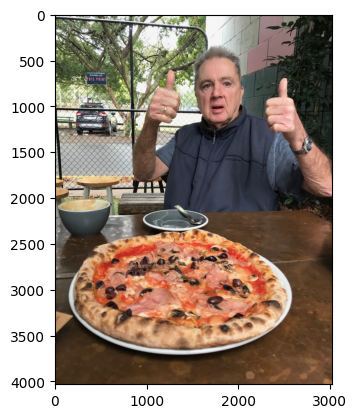

In [55]:
# divide the image tensor by 255 to get it in the range [0,1]

custom_image = custom_image_uint8 / 255

print(custom_image[:1],'\n')
print(custom_image.shape)
plt.imshow(custom_image.permute(1,2,0))

In [57]:
# resize the image 

custom_image_transfrom = transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed = custom_image_transfrom(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [65]:
# model infernece 

model_1.eval()
with torch.inference_mode():
    pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

print(pred)

tensor([[ 0.0395,  0.1499, -0.1122]], device='cuda:0')


In [66]:
# Print out prediction logits
print(f"Prediction logits: {pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

class_name = train_data.classes[custom_image_pred_label]
print(class_name)

Prediction logits: tensor([[ 0.0395,  0.1499, -0.1122]], device='cuda:0')
Prediction probabilities: tensor([[0.3360, 0.3752, 0.2887]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')
steak


**Putting custom image prediction together: building a function**

In [74]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        transform = None,
                        class_names: List[str] = None, 
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

c:\Users\kaila\Learning\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


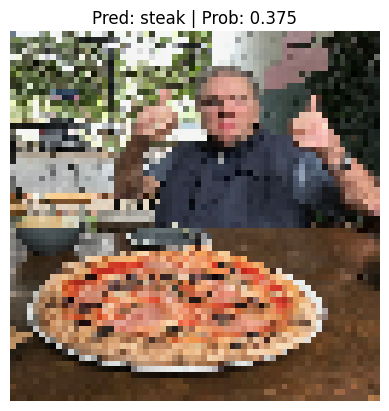

In [76]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transfrom,
                    device=device)